# Football Player Performance Prediction

## Project Overview

This Jupyter notebook implements a machine learning pipeline with a deep learning component to predict the overall performance ratings of football players using data from a SQLite database (`database.sqlite`). The dataset includes player attributes (e.g., dribbling, shooting, passing) and personal details (e.g., birth year, height, weight). Three models are developed and compared:

- **Neural Network (NN)**: A deep learning model built with Keras, optimized using KerasTuner to tune the number of layers, units per layer, and learning rate for enhanced performance.
- **Random Forest**: An ensemble machine learning model using decision trees, implemented with scikit-learn, offering robust and interpretable predictions.
- **XGBoost**: A gradient boosting machine learning model implemented with the XGBoost library, known for its efficiency and accuracy in regression tasks.

The pipeline includes data loading, preprocessing (e.g., handling missing values, encoding categorical features, scaling), visualization (e.g., rating distributions, correlation heatmaps), model training, hyperparameter tuning for the Neural Network, and evaluation. A comparison analysis assesses the models based on Mean Squared Error (MSE) and Mean Absolute Error (MAE), highlighting trade-offs in accuracy, interpretability, and computational efficiency. Visualizations and performance metrics provide insights into the data and model effectiveness.

# Data Loading
Import necessary libraries and frameworks for the project and load the SQLite database and reading the Player and Player_Attributes tables into DataFrames.

In [214]:
import os
import random
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Set display options for pandas
pd.set_option('display.max_columns', None)

SEED = 42

# Set the Python hash seed
os.environ['PYTHONHASHSEED'] = str(SEED)

# Configure TensorFlow for deterministic operations
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Set seeds for all relevant libraries
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [215]:
# Establish connection to the SQLite database
connection = sqlite3.connect('/kaggle/input/soccer/database.sqlite')

# Load the tables into DataFrames
players_df = pd.read_sql_query("SELECT * FROM Player", connection)
stats_df = pd.read_sql_query("SELECT * FROM Player_Attributes", connection)

In [216]:
players_df

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154
...,...,...,...,...,...,...,...
11055,11071,26357,Zoumana Camara,2488,1979-04-03 00:00:00,182.88,168
11056,11072,111182,Zsolt Laczko,164680,1986-12-18 00:00:00,182.88,176
11057,11073,36491,Zsolt Low,111191,1979-04-29 00:00:00,180.34,154
11058,11074,35506,Zurab Khizanishvili,47058,1981-10-06 00:00:00,185.42,172


In [217]:
stats_df

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,63.0,41.0,45.0,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183973,183974,102359,39902,2009-08-30 00:00:00,83.0,85.0,right,medium,low,84.0,77.0,59.0,89.0,77.0,84.0,86.0,78.0,84.0,85.0,66.0,72.0,77.0,86.0,73.0,76.0,58.0,72.0,67.0,81.0,56.0,78.0,86.0,88.0,83.0,22.0,31.0,30.0,9.0,20.0,84.0,20.0,20.0
183974,183975,102359,39902,2009-02-22 00:00:00,78.0,80.0,right,medium,low,74.0,76.0,53.0,84.0,77.0,85.0,86.0,74.0,73.0,86.0,66.0,67.0,77.0,74.0,73.0,75.0,58.0,66.0,65.0,73.0,61.0,64.0,72.0,88.0,70.0,32.0,31.0,30.0,9.0,20.0,73.0,20.0,20.0
183975,183976,102359,39902,2008-08-30 00:00:00,77.0,80.0,right,medium,low,74.0,71.0,53.0,84.0,77.0,85.0,86.0,74.0,73.0,86.0,66.0,67.0,77.0,74.0,73.0,75.0,58.0,66.0,65.0,73.0,67.0,64.0,72.0,88.0,70.0,32.0,31.0,30.0,9.0,20.0,73.0,20.0,20.0
183976,183977,102359,39902,2007-08-30 00:00:00,78.0,81.0,right,medium,low,74.0,64.0,57.0,86.0,77.0,87.0,86.0,73.0,73.0,91.0,61.0,60.0,77.0,69.0,73.0,72.0,58.0,67.0,59.0,78.0,63.0,63.0,68.0,88.0,53.0,28.0,32.0,30.0,9.0,20.0,73.0,20.0,20.0


# Preprocessing
We define the preprocessing functions and apply them to prepare the data for modeling, including feature engineering, encoding, scaling, and train-test splitting.

In [218]:
def onehot_encode(df, column):
    df = df.copy()
    dummies = pd.get_dummies(df[column], prefix=column)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)
    return df

In [219]:
def preprocess_inputs(players, stats):
    players = players.copy()
    stats = stats.copy()
    
    # Drop unused columns
    players = players.drop(['id', 'player_name', 'player_fifa_api_id'], axis=1)
    stats = stats.drop(['id', 'player_fifa_api_id', 'date'], axis=1)

    ## Players df: Feature Engineering on birthday
    players['birthday'] = pd.to_datetime(players['birthday'])
    players['birth_year'] = players['birthday'].apply(lambda x: x.year)
    players['birth_month'] = players['birthday'].apply(lambda x: x.month)
    players['birth_day'] = players['birthday'].apply(lambda x: x.day)
    players = players.drop('birthday', axis=1)

    ## Stats df: Aggregate player stats
    # Separate categorical features to avoid them being averaged
    categoricals = stats.groupby('player_api_id', as_index=False)[['preferred_foot', 'attacking_work_rate', 'defensive_work_rate']].first()
    
    # Clean up NaN values
    for column in ['attacking_work_rate', 'defensive_work_rate']:
        categoricals[column] = categoricals[column].apply(lambda x: np.NaN if x not in ['low', 'medium', 'high'] else x)
        categoricals[column] = categoricals[column].fillna(categoricals[column].mode()[0])
        
    # Take the average of all numeric stats for each player
    stats = stats.groupby('player_api_id').mean(numeric_only=True).reset_index()
    stats = stats.merge(categoricals, on='player_api_id')

    # Fill any remaining missing numeric values with the column mean
    for column in stats.select_dtypes(include=np.number).columns:
        if stats[column].isnull().sum() > 0:
            stats[column] = stats[column].fillna(stats[column].mean())
    
    ## Merge players and stats DataFrames
    df = players.merge(stats, on='player_api_id')
    df = df.drop('player_api_id', axis=1)
    
    # Encode categorical features
    df['preferred_foot'] = df['preferred_foot'].replace({'left': 0, 'right': 1})
    for column in ['attacking_work_rate', 'defensive_work_rate']:
        df = onehot_encode(df, column=column)
    
    # Split df into features (X) and target (y)
    y = df['overall_rating']
    X = df.drop('overall_rating', axis=1)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)
    
    # Scale feature data
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
    
    return X_train, X_test, y_train, y_test

In [220]:
X_train, X_test, y_train, y_test = preprocess_inputs(players_df, stats_df)

/tmp/ipykernel_36/3273898184.py:39: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['preferred_foot'] = df['preferred_foot'].replace({'left': 0, 'right': 1})


# Data Visualization
This section includes visualizations of the target variable `overall rating` distribution and the correlation heatmap of the top features.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


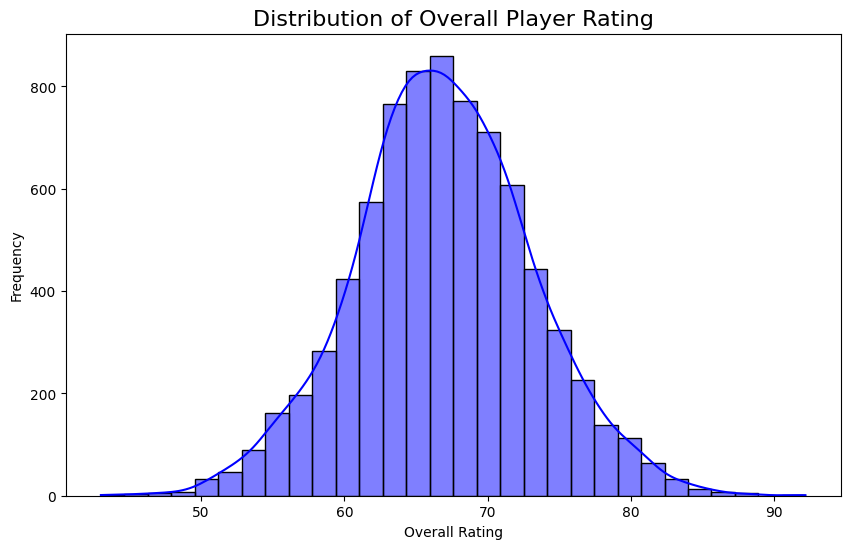

In [221]:
# Distribution of overall rating
plt.figure(figsize=(10, 6))
sns.histplot(y_train, kde=True, bins=30, color='blue')
plt.title('Distribution of Overall Player Rating', fontsize=16)
plt.xlabel('Overall Rating')
plt.ylabel('Frequency')
plt.show()

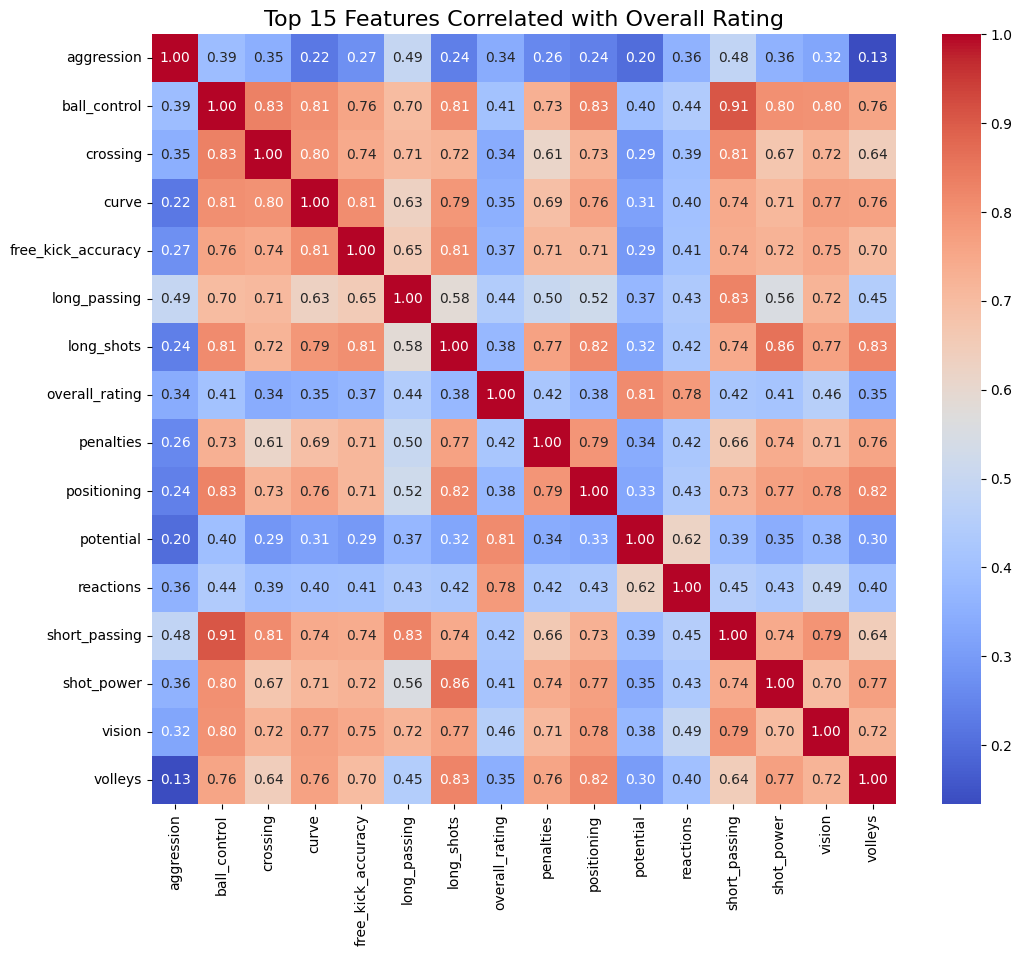

In [222]:
# Combine training data for correlation analysis
train_df = pd.concat([X_train, y_train], axis=1)

# Calculate correlations
correlations = train_df.corr()['overall_rating'].sort_values(ascending=False)
top_features = correlations[1:16].index
corr_matrix = train_df[top_features.union(['overall_rating'])].corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Top 15 Features Correlated with Overall Rating', fontsize=16)
plt.show()

# Neural Network Model
Define and compile an artificial neural network model using Tensorflow and Keras

In [223]:
# Building a Neural Network
model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

# Compile
model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_44 (Dense)                │ (None, 128)            │         6,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,385 (64.00 KB)

 Trainable params: 16,385 (64.00 KB)

 Non-trainable params: 0 (0.00 B)

# Model Training

In [224]:
print("Training Neural Network model...")
start_time = time.time()

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=64,
    epochs=50,
    verbose=1
)

nn_training_time = time.time() - start_time
print(f"\nNeural Network training took: {nn_training_time:.2f} seconds")

Training Neural Network model...
Epoch 1/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2725.2097 - mean_absolute_error: 47.0490 - val_loss: 69.7693 - val_mean_absolute_error: 6.6284
Epoch 2/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 51.0330 - mean_absolute_error: 5.6046 - val_loss: 30.1040 - val_mean_absolute_error: 4.2913
Epoch 3/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 24.7463 - mean_absolute_error: 3.8898 - val_loss: 20.0578 - val_mean_absolute_error: 3.5025
Epoch 4/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 16.8334 - mean_absolute_error: 3.1926 - val_loss: 14.6382 - val_mean_absolute_error: 2.9935
Epoch 5/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12.3525 - mean_absolute_error: 2.7316 - val_loss: 11.1393 - val_mean_absolute_error: 2.6104
Epoch 6/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.3251 - mean_absolute_error: 2.3686 - val_loss: 8.7006 - val_mean_absolute_error: 2.3059
Epoch 7/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - 

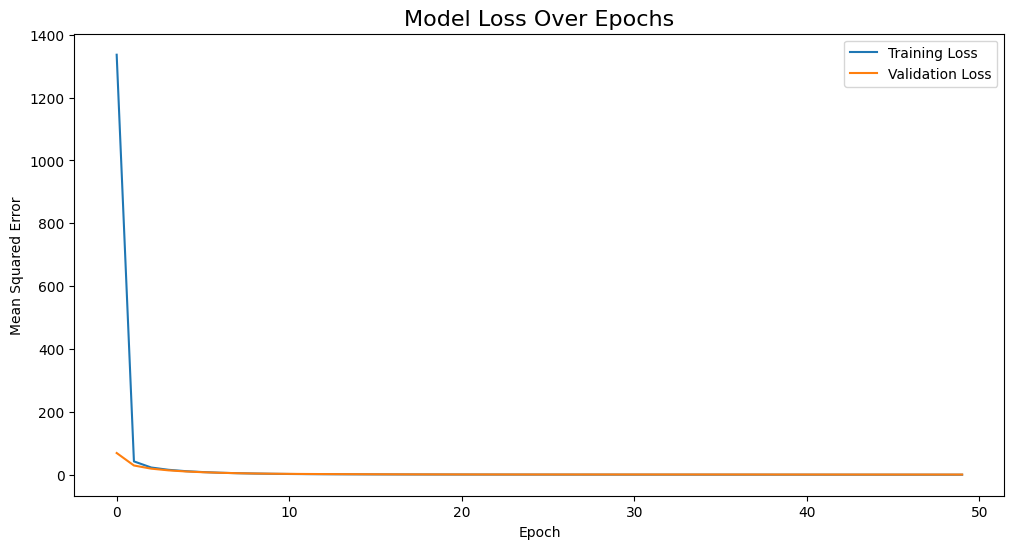

In [225]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs', fontsize=16)
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

# Model Evaluation

In [226]:
# Evaluate the model on the test set
test_loss, nn_mae = model.evaluate(X_test, y_test, verbose=0)

print(f"Test Set Mean Squared Error: {test_loss:.2f}")
print(f"Test Set Mean Absolute Error: {nn_mae:.2f}")

# An MAE of ~2.0 would mean our model's predictions are, on average, off by 2 rating points.

Test Set Mean Squared Error: 1.32
Test Set Mean Absolute Error: 0.88


In [227]:
# Get predictions on the test set
predictions = model.predict(X_test).flatten()

# Create a DataFrame for comparison
results_df = pd.DataFrame({
    'Actual Rating': y_test,
    'Predicted Rating': predictions
})
results_df['Error'] = results_df['Actual Rating'] - results_df['Predicted Rating']

print("Sample of Predictions vs. Actual Values:")
print(results_df.head(10))

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Sample of Predictions vs. Actual Values:
       Actual Rating  Predicted Rating     Error
9853       69.285714         68.795288  0.490426
6847       73.769231         72.450256  1.318974
9043       70.360000         70.669678 -0.309678
2939       60.500000         60.331608  0.168392
4257       62.875000         63.871651 -0.996651
9139       72.166667         74.008743 -1.842077
10731      66.375000         66.653122 -0.278122
8936       66.647059         66.322281  0.324778
6537       76.062500         76.746017 -0.683517
9213       66.133333         66.035568  0.097765


# Comparative Analysis
Compare the neural network's performance against two powerful and widely-used traditional ML models: Random Forest and XGBoost.

## Model 1 - Random Forest
A Random Forest is an ensemble model that builds multiple decision trees and merges them to get a more accurate and stable prediction. It's robust and often works great right out of the box.

In [228]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import time

# Instantiate the model (n_jobs=-1 uses all available CPU cores)
rf_model = RandomForestRegressor(n_estimators=100, random_state=1, n_jobs=-1)

# Time the training process
print("Training Random Forest model...")
start_time = time.time()
rf_model.fit(X_train, y_train)
rf_training_time = time.time() - start_time

# Make predictions and evaluate
rf_predictions = rf_model.predict(X_test)
rf_mae = mean_absolute_error(y_test, rf_predictions)

print(f"Random Forest MAE: {rf_mae:.4f}")
print(f"Training took: {rf_training_time:.2f} seconds")

Training Random Forest model...
Random Forest MAE: 1.1147
Training took: 5.46 seconds


## Model 2 - XGBoost
XGBoost (Extreme Gradient Boosting) is another ensemble method that builds decision trees sequentially, with each new tree correcting the errors of the previous one. It's famous for its high performance and speed.

In [229]:
import xgboost as xgb

# Instantiate the model
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=1, n_jobs=-1)

# Time the training process
print("Training XGBoost model...")
start_time = time.time()
xgb_model.fit(X_train, y_train)
xgb_training_time = time.time() - start_time

# Make predictions and evaluate
xgb_predictions = xgb_model.predict(X_test)
xgb_mae = mean_absolute_error(y_test, xgb_predictions)

print(f"XGBoost MAE: {xgb_mae:.4f}")
print(f"Training took: {xgb_training_time:.2f} seconds")

Training XGBoost model...
XGBoost MAE: 0.9328
Training took: 0.57 seconds


## Final Results


In [230]:
results_summary = pd.DataFrame({
    'Model': ['Neural Network', 'Random Forest', 'XGBoost'],
    'Test MAE': [nn_mae, rf_mae, xgb_mae],
    'Training Time (s)': [nn_training_time, rf_training_time, xgb_training_time]
})

results_summary = results_summary.sort_values(by='Test MAE', ascending=True).reset_index(drop=True)

print("--- Model Performance Comparison ---")
print(results_summary)

--- Model Performance Comparison ---
            Model  Test MAE  Training Time (s)
0  Neural Network  0.877627          21.044687
1         XGBoost  0.932808           0.569514
2   Random Forest  1.114699           5.459440


## Conclusion
The **Neural Network** model delivered the best predictive performance, achieving the **lowest** Mean Absolute Error of the three. While the **XGBoost** model was the **fastest** to train, the neural network's superior accuracy makes it the most effective model for this prediction task.

This result highlights the ability of a neural network to capture complex, non-linear relationships within the player attribute data, ultimately leading to more precise overall_rating predictions than the tree-based ensemble methods. Where predictive accuracy is the primary goal, the additional training time for the neural network is a worthwhile trade-off.